# Load Packages and Data

In [73]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from stepmix.stepmix import StepMix
from sklearn.preprocessing import StandardScaler

In [118]:
df = pd.read_csv('Survey_2024_Themed_Cleaned.csv')
df['Date'] = pd.to_datetime(df['Date'])
df['Start_Date'] = pd.to_datetime(df['Start_Date'])
df['End_Date'] = pd.to_datetime(df['End_Date'])
df.set_index('ID', inplace=True)

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_info_columns', 200)

df.info()

<class 'pandas.DataFrame'>
RangeIndex: 7522 entries, 1 to 7522
Data columns (total 125 columns):
 #    Column                                           Non-Null Count  Dtype         
---   ------                                           --------------  -----         
 0    Start_Date                                       7522 non-null   datetime64[us]
 1    End_Date                                         7522 non-null   datetime64[us]
 2    Date                                             7522 non-null   datetime64[us]
 3    Membership                                       7522 non-null   int64         
 4    Residence                                        7522 non-null   str           
 5    Postal                                           6653 non-null   str           
 6    Enth_British                                     7522 non-null   int64         
 7    Enth_French                                      7522 non-null   int64         
 8    Enth_Europe                          

# Segmentation Analysis

In [119]:
theme_cols = [c for c in df.columns if c.startswith("theme_") and c.endswith("_flag")]
sat_cols = [c for c in df.columns if c.startswith("Sat_") and not c.endswith('_Mean') and not c.endswith('_Skipped')]

sat_skipped_cols = [col for col in df.columns if col.startswith('Sat_') and col.endswith('_Skipped')]

low_sat_cols = []

for c in sat_cols:
    newc = f"{c}_low"
    df[newc] = np.where(df[c].notna() & (df[c] <= 3), 1, 0) 
    low_sat_cols.append(newc)

df['Subareas Skipped'] = df[[col for col in df.columns if col.endswith('_Unattended')]].sum(axis=1)
df.rename(columns={'Recommender': 'Recommended', 'Membership': 'Members'}, inplace=True)
demo_cols = ["Members", "Local", "Subareas Skipped", "Recommended"]
    
lca_features = theme_cols + low_sat_cols + sat_skipped_cols

X_meas = df[lca_features].astype(int)
outcome_cols = ["Overall_Sat", "Likely_Rec"]

Y_struct = df[outcome_cols].astype(float)

model_cols = lca_features + outcome_cols + demo_cols
df_model = df[model_cols].copy()

X_meas_m = df_model[lca_features].astype(int)
Y_struct_m = df_model[outcome_cols].astype(float)

X_all = pd.concat([X_meas_m, Y_struct_m], axis=1)
X_all_np = X_all.to_numpy(dtype=np.float64)


C:\Users\natha\AppData\Local\Temp\ipykernel_43160\3573386788.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[newc] = np.where(df[c].notna() & (df[c] <= 3), 1, 0)
C:\Users\natha\AppData\Local\Temp\ipykernel_43160\3573386788.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Subareas Skipped'] = df[[col for col in df.columns if col.endswith('_Unattended')]].sum(axis=1)


In [35]:
df[demo_cols].describe()

,Membership,Below_Median_Income,Local,Visible_Minority,Num_Areas_Unattended,Recommender
count,7522.000000,7522.000000,7522.000000,7522.000000,7522.000000,7522.000000
mean,0.423956,0.441106,0.664717,0.299123,5.426748,0.660861
std,0.494216,0.496552,0.472121,0.457904,2.944872,0.473448
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,5.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,8.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,13.000000,1.000000


In [36]:
corr_matrix = X_meas.corr()
high_corr = corr_matrix.where(np.triu(np.ones_like(corr_matrix), k=1).astype(bool))
high_corr_pairs = high_corr.stack().reset_index()
high_corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']
high_corr_pairs = high_corr_pairs[high_corr_pairs['Correlation'].abs() > 0.5]
high_corr_pairs.sort_values('Correlation', ascending=False)

,Feature1,Feature2,Correlation
505,Sat_Emp_Helpfulness_low,Sat_Vol_Helpfulness_low,0.576033
254,Sat_Value_low,Sat_Variety_low,0.524798
325,Sat_Variety_low,Sat_Signs_low,0.515445
590,Sat_Gift_Shops_low,Sat_Gift_Shops_Skipped,-0.518360
626,Sat_Food_low,Sat_Food_Skipped,-0.594251


In [37]:
results = []
models = {}

Ks = range(2, 16)

for K in Ks:
    model = StepMix(
        n_components=K,
        measurement="bernoulli", 
        structural="gaussian",
        n_init=10,
        max_iter=1000,
        random_state=123
    )
    model.fit(X_all_np)

    post = model.predict_proba(X_all_np)
    post = np.clip(post, 1e-12, 1.0)
    bic = model.bic(X_all_np)
    aic = model.aic(X_all_np)
    H = -np.sum(post * np.log(post), axis=1).mean()
    entropy = 1 - (H / np.log(K)) 

    results.append({"K": K, "BIC": bic, "AIC": aic, "Entropy": entropy})
    models[K] = model

fit_df = pd.DataFrame(results).sort_values("BIC")
fit_df

Fitting StepMix...


Initializations (n_init) : 100%|██████████| 10/10 [00:00<00:00, 10.84it/s, max_LL=2.42e+6, max_avg_LL=321]


Fitting StepMix...


Initializations (n_init) : 100%|██████████| 10/10 [00:03<00:00,  2.60it/s, max_LL=2.42e+6, max_avg_LL=322]


Fitting StepMix...


Initializations (n_init) : 100%|██████████| 10/10 [00:04<00:00,  2.45it/s, max_LL=2.42e+6, max_avg_LL=322]


Fitting StepMix...


Initializations (n_init) : 100%|██████████| 10/10 [00:09<00:00,  1.01it/s, max_LL=2.42e+6, max_avg_LL=322]


Fitting StepMix...


Initializations (n_init) : 100%|██████████| 10/10 [00:06<00:00,  1.45it/s, max_LL=2.42e+6, max_avg_LL=322]


Fitting StepMix...


Initializations (n_init) : 100%|██████████| 10/10 [00:14<00:00,  1.41s/it, max_LL=2.42e+6, max_avg_LL=322]


Fitting StepMix...


Initializations (n_init) : 100%|██████████| 10/10 [00:16<00:00,  1.68s/it, max_LL=2.42e+6, max_avg_LL=322]


Fitting StepMix...


Initializations (n_init) : 100%|██████████| 10/10 [00:21<00:00,  2.10s/it, max_LL=2.42e+6, max_avg_LL=322]


Fitting StepMix...


Initializations (n_init) : 100%|██████████| 10/10 [00:22<00:00,  2.22s/it, max_LL=2.42e+6, max_avg_LL=322]


Fitting StepMix...


Initializations (n_init) : 100%|██████████| 10/10 [00:27<00:00,  2.77s/it, max_LL=2.42e+6, max_avg_LL=322]


Fitting StepMix...


Initializations (n_init) : 100%|██████████| 10/10 [00:29<00:00,  2.96s/it, max_LL=2.42e+6, max_avg_LL=322]


Fitting StepMix...


Initializations (n_init) : 100%|██████████| 10/10 [00:25<00:00,  2.53s/it, max_LL=2.43e+6, max_avg_LL=322]


Fitting StepMix...


Initializations (n_init) : 100%|██████████| 10/10 [00:31<00:00,  3.11s/it, max_LL=2.43e+6, max_avg_LL=322]


Fitting StepMix...


Initializations (n_init) : 100%|██████████| 10/10 [00:34<00:00,  3.45s/it, max_LL=2.43e+6, max_avg_LL=322]


,K,BIC,AIC,Entropy
13,15,-4.846171e+06,-4.850112e+06,0.832964
12,14,-4.846149e+06,-4.849827e+06,0.831142
11,13,-4.846086e+06,-4.849500e+06,0.831860
10,12,-4.845838e+06,-4.848989e+06,0.830389
9,11,-4.845703e+06,-4.848591e+06,0.832043
8,10,-4.845442e+06,-4.848067e+06,0.830086
7,9,-4.845125e+06,-4.847486e+06,0.817227
6,8,-4.844558e+06,-4.846657e+06,0.818528
5,7,-4.844228e+06,-4.846063e+06,0.826193
4,6,-4.843562e+06,-4.845134e+06,0.837995


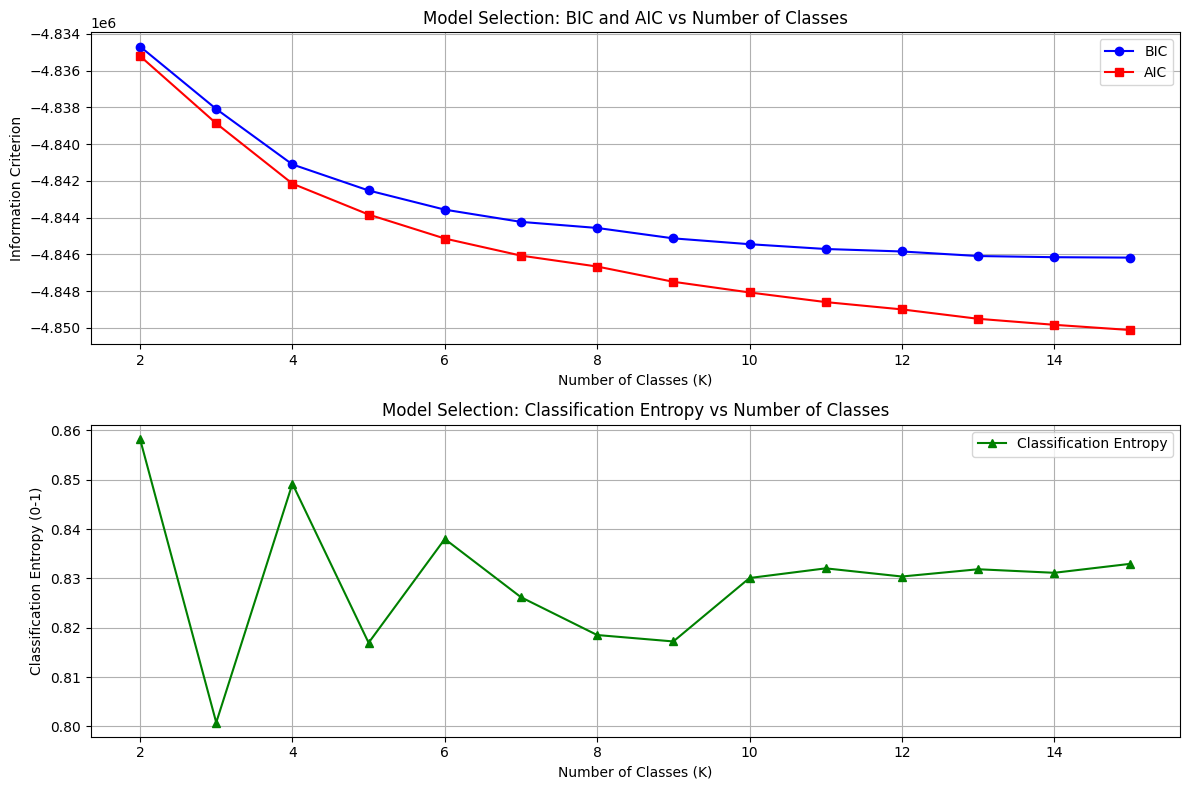

,K,BIC,AIC,Entropy
13,15,-4.846171e+06,-4.850112e+06,0.832964
12,14,-4.846149e+06,-4.849827e+06,0.831142
11,13,-4.846086e+06,-4.849500e+06,0.831860
10,12,-4.845838e+06,-4.848989e+06,0.830389
9,11,-4.845703e+06,-4.848591e+06,0.832043
8,10,-4.845442e+06,-4.848067e+06,0.830086
7,9,-4.845125e+06,-4.847486e+06,0.817227
6,8,-4.844558e+06,-4.846657e+06,0.818528
5,7,-4.844228e+06,-4.846063e+06,0.826193
4,6,-4.843562e+06,-4.845134e+06,0.837995


In [38]:
# Plot BIC, AIC, and Classification Entropy vs K
plt.figure(figsize=(12, 8))

# BIC and AIC on left y-axis
ax1 = plt.subplot(2, 1, 1)
ax1.plot(fit_df['K'], fit_df['BIC'], marker='o', label='BIC', color='blue')
ax1.plot(fit_df['K'], fit_df['AIC'], marker='s', label='AIC', color='red')
ax1.set_xlabel('Number of Classes (K)')
ax1.set_ylabel('Information Criterion')
ax1.set_title('Model Selection: BIC and AIC vs Number of Classes')
ax1.legend()
ax1.grid(True)

# Classification Entropy on right y-axis
ax2 = plt.subplot(2, 1, 2)
ax2.plot(fit_df['K'], fit_df['Entropy'], marker='^', label='Classification Entropy', color='green')
ax2.set_xlabel('Number of Classes (K)')
ax2.set_ylabel('Classification Entropy (0-1)')
ax2.set_title('Model Selection: Classification Entropy vs Number of Classes')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Display the table
fit_df

In [63]:
best_K = 4
best_model = models[best_K]

post = best_model.predict_proba(X_all_np)

df_model["segment_conf"] = post.max(axis=1)

Xb = X_meas.to_numpy(dtype=np.float64)    # n x p (binary)
G  = post.astype(np.float64)              # n x K

den = G.sum(axis=0) + 1e-12               # K,
num = G.T @ Xb                            # K x p

theta_hat = num / den[:, None]            # K x p
theta_df = pd.DataFrame(
    theta_hat,
    columns=lca_features,
    index=[f"segment_{k+1}" for k in range(best_K)]
)

overall_prev = X_meas.mean(axis=0)         # p,
lift_df = theta_df - overall_prev  


In [88]:
cols = [c for c in lift_df.columns if  c.endswith("_low")]
seg_names = ["Smooth Visit", "Value-Sensitive, Low Engagement", "Engaged but Frustrated", "High-Friction"]

lift_heatmap_df = lift_df[cols].copy()
order_cols = (lift_heatmap_df.iloc[1] - lift_heatmap_df.iloc[2]).abs().sort_values(ascending=False).index
lift_heatmap_df = lift_heatmap_df[order_cols]
lift_heatmap_df.index = seg_names

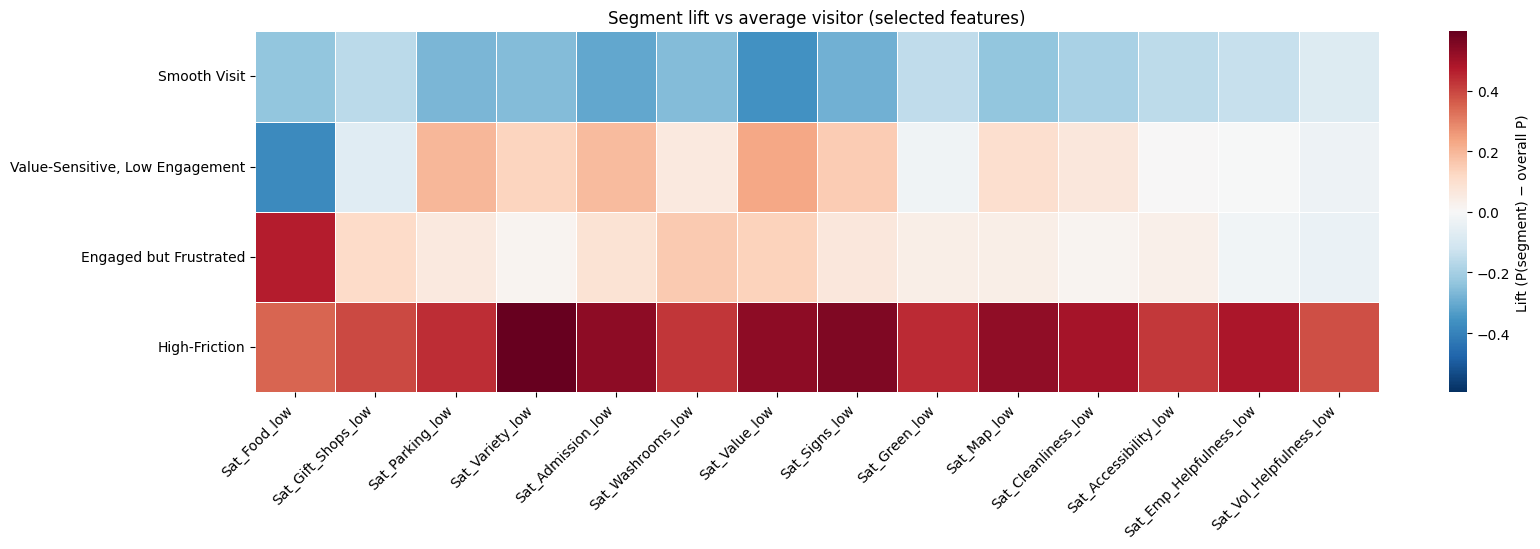

In [89]:
# heatmap for lift_heatmap_df
vmax = float(lift_heatmap_df.abs().values.max())
vmin = -vmax

fig, ax = plt.subplots(figsize=(1.2 * lift_heatmap_df.shape[1], 0.9 * lift_heatmap_df.shape[0] + 2))
sns.heatmap(
    lift_heatmap_df,
    ax=ax,
    cmap="RdBu_r",
    vmin=vmin,
    vmax=vmax,
    center=0.0,
    cbar_kws={"label": "Lift (P(segment) − overall P)"},
    annot=False,
    linewidths=0.5
)
ax.set_title("Segment lift vs average visitor (selected features)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [131]:
n_soft = den
pi_soft = n_soft / n_soft.sum()

demo_vals = df_model[demo_cols].to_numpy(dtype=np.float64)  # n x d
demo_num = (G.T @ demo_vals) / n_soft[:, None]      # K x d
demo_num = pd.DataFrame(
    (demo_num*100).round(2),
    columns=[f"Percent {c}" for c in demo_cols],
    index=range(1, best_K+1)
)
demo_num.index = seg_names
demo_num['Total Number'] = n_soft.round(0).astype(int)
demo_num['Percentage of Sample'] = (pi_soft*100).round(2)
demo_num['Percent Subareas Skipped'] = (demo_num['Percent Subareas Skipped']/100).round(2)
demo_num.rename(columns={'Percent Subareas Skipped': 'Avg. Subareas Skipped'}, inplace=True)
demo_num = demo_num[['Total Number', 'Percentage of Sample'] + [col for col in demo_num.columns if col not in ['Total Number', 'Percentage of Sample']]]
demo_num


,Total Number,Percentage of Sample,Percent Members,Percent Local,Avg. Subareas Skipped,Percent Recommended
Smooth Visit,3094,41.14,51.26,70.24,5.62,94.39
"Value-Sensitive, Low Engagement",1454,19.34,43.48,69.91,6.00,50.63
Engaged but Frustrated,2010,26.72,37.06,61.97,5.35,58.75
High-Friction,963,12.80,23.42,58.57,4.08,13.79
